# Closed-Form Matting with Scribbles

## Accurate Alpha Matte Estimation from Minimal User Input  
*Based on the Python implementation of image matting method proposed in A. Levin D. Lischinski and Y. Weiss. A Closed Form Solution to Natural Image Matting. IEEE Conf. on Computer Vision and Pattern Recognition (CVPR), June 2006, New York that can be found on https://github.com/MarcoForte/closed-form-matting*

- biagio.cancelliere@mail.polimi.it
- davide1.franchi@mail.polimi.it
- carlos2.ruiz@mail.polimi.it

This notebook provides an explanation of the mentioned **Closed-Form Matting** technique for natural images. The goal is to compute a continuous **alpha matte** $ \alpha(x, y) \in [0, 1] $, which represents the per-pixel opacity of the foreground object in a scene.

Using sparse user annotations in the form of **scribbles**—indicating definite foreground and background regions—the method propagates the known alpha values across the image while preserving edges and local color statistics.

## Table of Contents

1. [Introduction](#introduction)
2. [Setup and Dependencies](#setup-and-dependencies)
3. [Data Preparation](#data-preparation)  
   3.1 [Loading the Input Image and Scribbles](#loading-the-input-image-and-scribbles)  
   3.2 [Visualizing the Inputs](#visualizing-the-inputs)
4. [Alpha Prior from Scribbles](#alpha-prior-from-scribbles)
5. [Matting Laplacian Construction](#matting-laplacian-construction)
6. [Solving for the Alpha Matte](#solving-for-the-alpha-matte)
7. [Result Visualization and Analysis](#result-visualization-and-analysis)
8. [Conclusions and Further Reading](#conclusions-and-further-reading)


## 1. Introduction <a name="introduction"></a>

Natural image matting is the process of estimating the opacity (alpha value) of the foreground object in an image, separating it from the background. This task is essential in many applications, including image editing, film production, augmented reality, and compositing.

The **alpha matte** is a real-valued mask $ \alpha(x, y) \in [0, 1] $ that indicates the proportion of foreground present at each pixel:
- $ \alpha = 1 $: full foreground
- $ \alpha = 0 $: full background
- $ \alpha \in (0,1) $: partial or mixed pixels (e.g., along object boundaries or in regions of transparency)

Estimating an accurate alpha matte from a single image is highly ill-posed. To resolve this ambiguity, additional constraints are needed. One widely adopted approach is to use **user-provided annotations**, such as:
- **Scribbles** indicating known foreground and background pixels
- **Trimaps** that mark definite foreground, background, and unknown regions

In this notebook, we focus on the method proposed by **Levin et al. (2008)**, which formulates image matting as a **closed-form solution** by leveraging the local color distribution of the image. Their method constructs a **Matting Laplacian**, a sparse matrix that enforces smoothness of the alpha matte within small windows under a color line model.

Given a small set of user-defined scribbles, the method solves a sparse linear system to propagate alpha values across the image, producing a soft, edge-preserving alpha matte.

This notebook walks through the complete pipeline:
- Interpreting user scribbles as alpha constraints
- Constructing the matting Laplacian
- Solving for the alpha matte via linear system optimization
- Visualizing and interpreting the resulting alpha mask


## 2. Setup and Dependencies <a name="setup-and-dependencies"></a>

This section installs and imports the necessary Python libraries for image processing, numerical computation, and visualization.

Make sure to run this cell before proceeding.


In [83]:
# Install required packages (if not already available)
# Uncomment the following line if running in a clean environment (e.g., Colab)
# !pip install opencv-python-headless scipy matplotlib

import numpy as np
import cv2
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt

# Configure plots for consistent visual output
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["axes.grid"] = False

# Utility for displaying images
def imshow(img, title=None, cmap=None):
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or "gray")
    else:
        # OpenCV uses BGR; convert to RGB for display
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


## 3. Data Preparation <a name="data-preparation"></a>

To compute the alpha matte, we need two input images:

- The **original RGB image** containing the object to be segmented.
- A corresponding **scribbles image**, where the user has marked some pixels as definite foreground (typically white) and definite background (typically black).

The scribbles act as soft constraints that guide the matting algorithm.

The input and scribbles images must:
- Have the same dimensions
- Be in color (3-channel RGB/BGR)
- Be properly aligned

We will now load both images and display them to verify their correctness.


### 3.1 Loading the Input Image and Scribbles <a name="loading-the-input-image-and-scribbles"></a>


In [84]:
from typing import Tuple, Union

def _resize_pair(img: np.ndarray, scrib: np.ndarray, max_dim: Union[int, None]) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    If max_dim is not None and either dimension exceeds max_dim,
    compute a scale factor and resize both img and scrib to that scale,
    preserving aspect ratio. Returns (img_resized, scrib_resized, scale_factor).
    """
    h, w = img.shape[:2]
    if max_dim is None or max(h, w) <= max_dim:
        return img, scrib, 1.0

    scale = max_dim / max(h, w)
    new_size = (int(w * scale), int(h * scale))
    img_resized = cv2.resize(img, new_size, interpolation=cv2.INTER_AREA)
    scrib_resized = cv2.resize(scrib, new_size, interpolation=cv2.INTER_AREA)
    return img_resized, scrib_resized, scale


# Load images
image_path = "../assets/images/IMG_9264.png"
scribbles_path = "../assets/scribbles/IMG_9264_scribbles.png"

image_raw = cv2.imread(image_path, cv2.IMREAD_COLOR).astype(np.float32) / 255.0
scribbles_raw = cv2.imread(scribbles_path, cv2.IMREAD_COLOR).astype(np.float32) / 255.0

# Sanity check
assert image_raw is not None and scribbles_raw is not None, "Failed to load input images"
assert image_raw.shape == scribbles_raw.shape, "Image and scribbles must have the same dimensions"

# Resize if necessary
max_dim = 512  # Set maximum size for either dimension
image, scribbles, scale = _resize_pair(image_raw, scribbles_raw, max_dim)

print(f"Original shape: {image_raw.shape[:2]}, resized to: {image.shape[:2]}, scale factor: {scale:.3f}")


Original shape: (4032, 3024), resized to: (512, 384), scale factor: 0.127


### 3.2 Visualizing the Inputs <a name="visualizing-the-inputs"></a>


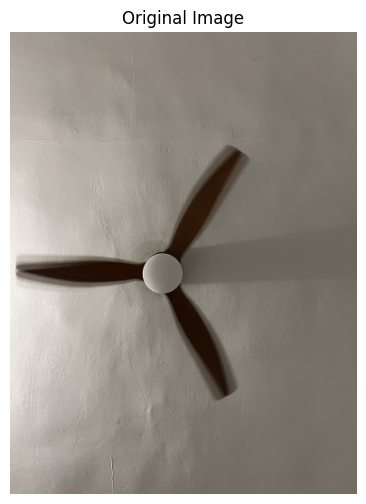

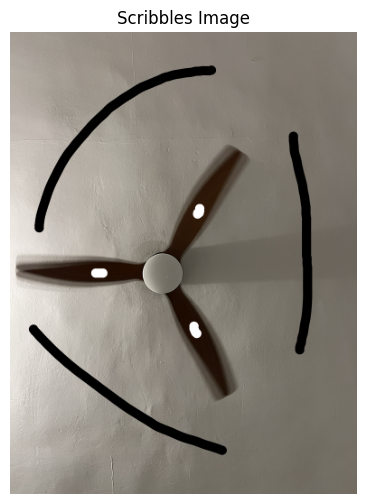

In [85]:
# Display original image
plt.figure()
imshow(image, "Original Image")
plt.show()

# Display scribbles overlay
plt.figure()
imshow(scribbles, "Scribbles Image")
plt.show()


## 4. Alpha Prior from Scribbles <a name="alpha-prior-from-scribbles"></a>

The matting algorithm requires an initial estimate of the alpha values—called the **alpha prior**—to guide the solution. This prior is derived directly from the scribbles image provided by the user.

### Interpretation of Scribbles

We assume the scribbles image consists of:
- **Black strokes** (RGB ≈ [0, 0, 0]) marking definite background
- **White strokes** (RGB ≈ [1, 1, 1]) marking definite foreground
- **Unmodified areas** (same as original image) representing unknown regions

We compute the alpha prior $\alpha_0(x, y)$ for each pixel using the formula:

$$
\alpha_0(x, y) = \frac{1}{2} \cdot \text{sign} \left( \sum_{c=1}^{3} (S_c(x, y) - I_c(x, y)) \right) + 0.5
$$

Where:
- $ S(x, y) $: the scribbles image
- $ I(x, y) $: the original image
- The result maps to:
  - $ \alpha_0 = 1 $: foreground (white scribble)
  - $ \alpha_0 = 0 $: background (black scribble)
  - $ \alpha_0 = 0.5 $: unknown (no scribble)

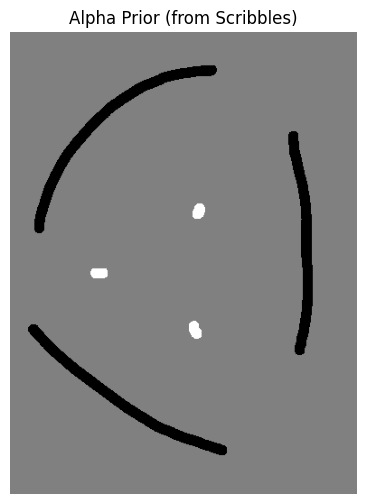

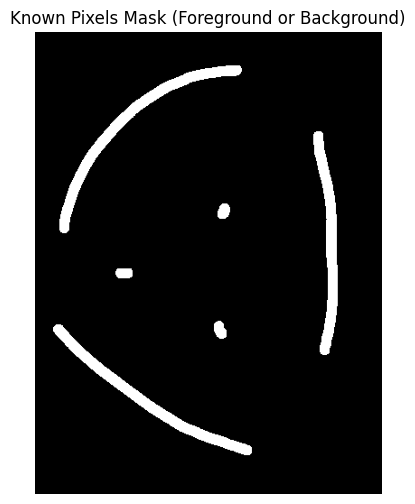

In [86]:
# Compute alpha prior from scribbles
prior = np.sign(np.sum(scribbles - image, axis=2)) / 2.0 + 0.5

# Define constant mask: where prior is either 0 or 1 (i.e., where user actually painted)
consts_map = (prior != 0.5).astype(np.float32)

# Display prior
plt.figure()
imshow(prior, "Alpha Prior (from Scribbles)", cmap="gray")
plt.show()

# Optionally visualize where scribbles exist (binary mask)
plt.figure()
imshow(consts_map, "Known Pixels Mask (Foreground or Background)", cmap="gray")
plt.show()


## 5. Matting Laplacian Construction <a name="matting-laplacian-construction"></a>

The **Matting Laplacian** is a key component of the Closed-Form Matting method proposed by Levin et al. It encodes the assumption that, within a small window, the colors of pixels lie approximately on a single line in RGB space. Based on this assumption, the Laplacian enforces that the estimated alpha values should vary smoothly in regions with homogeneous color, and should respect edges in the image.

Formally, the Matting Laplacian $ L $ is a sparse $ N \times N $ matrix (where $ N = H \times W $) that penalizes differences in alpha values between similar pixels in a local window.

### Window Definition

For each pixel, we consider a local square window of size $ (2r+1) \times (2r+1) $, typically with radius $ r = 1 $, i.e., a $ 3 \times 3 $ window.

For each window $ \omega_k $, the local contribution to the Laplacian is:

$$
L_{ij}^{(k)} = \delta_{ij} - \frac{1}{|\omega_k|} \left( 1 + (I_i - \mu_k)^T \left( \Sigma_k + \frac{\epsilon}{|\omega_k|} I_3 \right)^{-1} (I_j - \mu_k) \right)
$$

Where:
- $ I_i, I_j $: RGB values at pixels $ i $ and $ j $ within the window
- $ \mu_k $, $ \Sigma_k $: mean and covariance of RGB values in the window
- $ \epsilon $: small regularization constant (e.g., $10^{-7}$)

The total Laplacian is obtained by summing contributions over all overlapping windows.

### Computation Notes
- The Laplacian is implemented as a sparse matrix to scale to large images.
- We skip windows that are entirely inside known foreground/background regions (optional optimization).

We now define a function to compute the Laplacian matrix for a given image.


In [87]:
from numpy.lib.stride_tricks import as_strided

def _rolling_block(A, block=(3, 3)):
    """Extracts all (3x3) windows from matrix A using strides."""
    shape = (A.shape[0] - block[0] + 1, A.shape[1] - block[1] + 1) + block
    strides = A.strides * 2
    return as_strided(A, shape=shape, strides=strides)

def compute_laplacian(img: np.ndarray, mask=None, eps: float =10**(-7), win_rad: int =1):
    """Computes Matting Laplacian for a given image.

    Args:
        img: 3-dim numpy matrix with input image
        mask: mask of pixels for which Laplacian will be computed.
            If not set Laplacian will be computed for all pixels.
        eps: regularization parameter controlling alpha smoothness
            from Eq. 12 of the original paper. Defaults to 1e-7.
        win_rad: radius of window used to build Matting Laplacian (i.e.
            radius of omega_k in Eq. 12).
    Returns: sparse matrix holding Matting Laplacian.
    """

    win_size = (win_rad * 2 + 1) ** 2
    h, w, d = img.shape
    # Number of window centre indices in h, w axes
    c_h, c_w = h - 2 * win_rad, w - 2 * win_rad
    win_diam = win_rad * 2 + 1

    indsM = np.arange(h * w).reshape((h, w))
    ravelImg = img.reshape(h * w, d)
    win_inds = _rolling_block(indsM, block=(win_diam, win_diam))

    win_inds = win_inds.reshape(c_h, c_w, win_size)
    if mask is not None:
        mask = cv2.dilate(
            mask.astype(np.uint8),
            np.ones((win_diam, win_diam), np.uint8)
        ).astype(bool)
        win_mask = np.sum(mask.ravel()[win_inds], axis=2)
        win_inds = win_inds[win_mask > 0, :]
    else:
        win_inds = win_inds.reshape(-1, win_size)

    
    winI = ravelImg[win_inds]

    win_mu = np.mean(winI, axis=1, keepdims=True)
    win_var = np.einsum('...ji,...jk ->...ik', winI, winI) / win_size - np.einsum('...ji,...jk ->...ik', win_mu, win_mu)

    A = win_var + (eps/win_size)*np.eye(3)
    B = (winI - win_mu).transpose(0, 2, 1)
    X = np.linalg.solve(A, B).transpose(0, 2, 1)
    vals = np.eye(win_size) - (1.0/win_size)*(1 + X @ B)

    nz_indsCol = np.tile(win_inds, win_size).ravel()
    nz_indsRow = np.repeat(win_inds, win_size).ravel()
    nz_indsVal = vals.ravel()
    L = scipy.sparse.coo_matrix((nz_indsVal, (nz_indsRow, nz_indsCol)), shape=(h*w, h*w))

    # rewrite L in CSR format
    #L = scipy.sparse.csr_matrix((nz_indsVal, nz_indsCol, np.arange(0, nz_indsVal.shape[0] + 1, win_size)), shape=(h*w, h*w))
    return L.tocsr()


### 5.1 Computing and Visualizing the Laplacian

Once the Matting Laplacian construction function is in place, we can compute it for our specific image. To optimize performance and focus only on the unknown regions, we apply the Laplacian only to pixels where the alpha value is not already known from the scribbles (i.e., where the prior is equal to 0.5).

This section also visualizes the sparsity structure of the resulting Laplacian matrix. This visualization provides insight into how local pixel interactions are encoded—each row in the Laplacian corresponds to a pixel, and its non-zero entries define which neighboring pixels influence its alpha value.

A correctly formed Laplacian should:
- Be symmetric and positive semi-definite
- Contain non-zero entries mainly along and near the diagonal
- Exhibit a repeating banded structure due to window-based neighborhood interactions


Laplacian shape: (196608, 196608)
Non-zero entries: 4,772,855


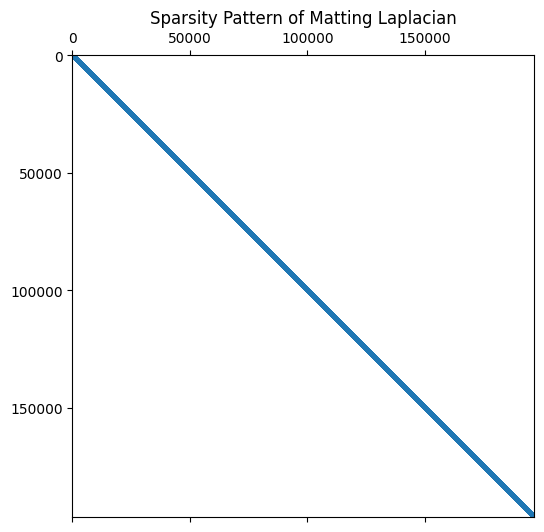

In [88]:
# Compute mask of unconstrained pixels (where alpha is unknown)
unconstrained_mask = (prior == 0.5).astype(np.uint8)

# Compute Laplacian only where needed
L = compute_laplacian(image, mask=unconstrained_mask)

print(f"Laplacian shape: {L.shape}")
print(f"Non-zero entries: {L.nnz:,}")
plt.spy(L, markersize=0.1)
plt.title("Sparsity Pattern of Matting Laplacian")
plt.show()


Due to the large size and high sparsity of the Matting Laplacian, a full-matrix visualization can appear nearly empty except for the main diagonal. To better understand its internal structure, we can zoom into a small top-left portion of the matrix—for example, the first 1000×1000 entries.

This zoomed view allows us to:

- Confirm that each pixel is connected to its local neighbors (e.g., through 3×3 windows)
- Observe the banded pattern around the diagonal
- Validate that the Laplacian encodes local connectivity and smoothness assumptions as expected

Keep in mind:
- The diagonal represents each pixel’s connection to itself
- The off-diagonal bands represent connections to nearby pixels (based on windowed neighborhoods)
- The vertical distance between bands is approximately equal to the image width, due to raster row-major ordering

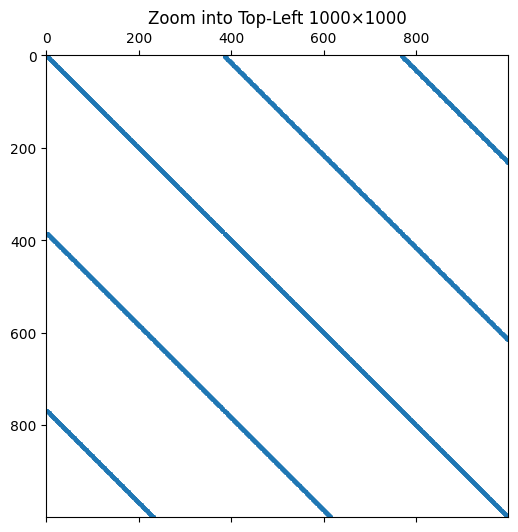

In [89]:
submatrix = L[:1000, :1000]
plt.spy(submatrix, markersize=1)
plt.title("Zoom into Top-Left 1000×1000")
plt.show()


## 6. Solving for the Alpha Matte <a name="solving-for-the-alpha-matte"></a>

With the Matting Laplacian $ L $ constructed and the alpha prior $ \alpha_0 $ defined from user scribbles, we now solve for the full alpha matte.

We minimize the following quadratic energy:

$$
\alpha^{*} = \arg\min_{\alpha} \; \alpha^\top L \alpha + (\alpha - \alpha_0)^\top C (\alpha - \alpha_0)
$$

Where:
- $ L $: the Matting Laplacian (enforces smoothness and local color consistency)
- $ \alpha_0 $: prior values (0, 0.5, or 1) derived from scribbles
- $ C $: diagonal confidence matrix (high confidence in scribbled pixels, zero elsewhere)

This results in a sparse linear system:

$$
(L + C)\, \alpha = C\, \alpha_0
$$

which we solve using a sparse direct solver.

The solution is a real-valued alpha matte $ \alpha(x, y) \in [0, 1] $ that respects user annotations while smoothly interpolating unknown regions based on the image structure.


Solving sparse linear system...


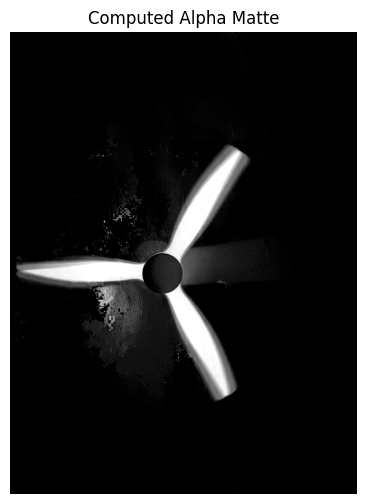

In [90]:
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Flattened versions
H, W = image.shape[:2]
N = H * W

# Confidence matrix: high (e.g. 100) where scribbles exist, zero elsewhere
confidence = 100.0
confidence_mask = (prior != 0.5).astype(np.float32)
C = diags((confidence * confidence_mask).ravel(), format="csr")

# Right-hand side: C * alpha_0
b = (confidence * confidence_mask * prior).ravel()

# Solve the sparse linear system: (L + C) α = C α₀
print("Solving sparse linear system...")
alpha_flat = spsolve(L + C, b)

# Clip to [0, 1] and reshape to image
alpha = np.clip(alpha_flat.reshape((H, W)), 0, 1)

# Show result
plt.figure()
imshow(alpha, "Computed Alpha Matte", cmap="gray")
plt.show()


## 7. Result Visualization and Analysis <a name="result-visualization-and-analysis"></a>

Once the alpha matte has been computed, we can visualize and analyze its quality in several ways:

1. **View the alpha matte directly**: this shows soft transitions around object boundaries and how well the scribbles propagated.
2. **Visualize the alpha overlayed on the original image**: this helps confirm whether alpha values align with object contours.
3. **Composite the foreground over a new background**: for example, a solid white or transparent background to simulate cutout.

This section provides practical tools to evaluate how well the alpha map separates foreground from background.


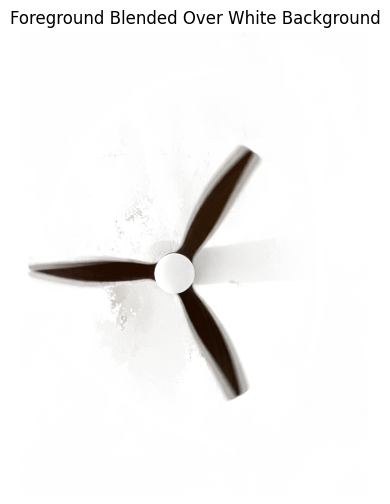

In [91]:
# Simple alpha blending: image * alpha + white * (1 - alpha)
foreground_rgb = image * alpha[..., np.newaxis] + (1 - alpha[..., np.newaxis]) * 1.0
foreground_rgb = foreground_rgb.astype(np.float32)

plt.figure()
imshow(foreground_rgb, "Foreground Blended Over White Background")
plt.show()


## 8. Conclusions and Further Reading <a name="conclusions-and-further-reading"></a>

In this notebook, we implemented and applied the **Closed-Form Matting** algorithm for natural images using sparse user annotations in the form of foreground/background scribbles.

### Key Takeaways

- The method computes a **soft alpha matte** \( \alpha(x, y) \in [0, 1] \), which smoothly separates foreground from background, especially around complex object boundaries.
- Scribbles are interpreted as **hard constraints** that are propagated across the image using a **Matting Laplacian**, which encodes local color consistency.
- Solving the system involves sparse linear algebra and benefits from the matrix's structure: sparse, symmetric, and positive semi-definite.
- The resulting alpha matte can be directly used for **object extraction, compositing, or visual effects**.

### Strengths

- Requires minimal user input (a few scribbles).
- Fully differentiable and fast (no iterative optimization).
- Produces smooth and realistic mattes even for soft edges.

### Limitations

- Assumes local color smoothness, which may fail in highly textured or low-contrast regions.
- Sensitive to incorrect or sparse scribbles in ambiguous areas.
- Not designed for real-time video or dynamic content without additional extensions.